In [2]:
from diffusers import StableDiffusionPipeline

LOW_RESOURCE = False 
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# stabilityai/stable-diffusion-2-1-base, CompVis/stable-diffusion-v1-4"
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = ldm_stable.tokenizer

/opt/conda/envs/ml/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
text_encoder/pytorch_model.fp16.safetensors not found


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [2]:
import pickle
with open('/home/royhirsch_google_com/image_editing/cat_dog_sd2_1__0_49.pickle', 'rb') as f:
    results = pickle.load(f)


In [9]:
results['results'][0]['h_space'][0].shape

torch.Size([2, 1280, 12, 12])

P2P

In [3]:
class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn
    
    
class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            print(self.cur_att_layer)
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class AttentionStoreAll(AttentionStore):
    
    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
        self.all_steps_store = []
        # self.text_input_save_ind = 9

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            attn_slice = attn
            attn_slice = attn_slice.detach().cpu()
            self.step_store[key].append(attn_slice)
        return attn

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.all_steps_store.append(self.step_store)
            self.between_steps()
        return attn


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer

from PIL import Image

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))


def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    ptp_utils.view_images(images)
    return images, x_t


  0%|          | 0/51 [00:00<?, ?it/s]

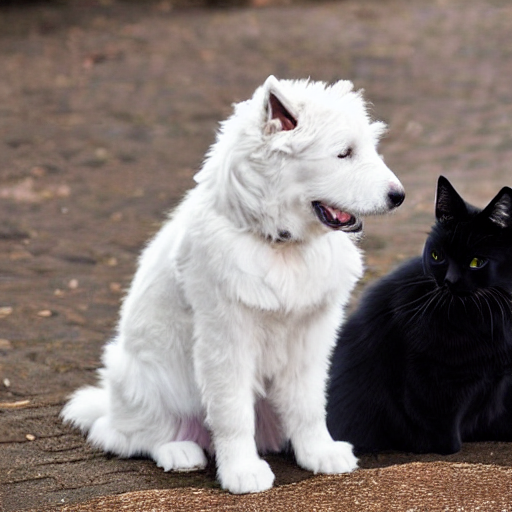

In [4]:
height = width = 512
g_cpu = torch.Generator().manual_seed(1)
prompts = ["A white dog and a balck cat"]
latent = torch.randn((1, ldm_stable.unet.in_channels, height // 8, width // 8), generator=g_cpu)
latents = latent.expand(1,  ldm_stable.unet.in_channels, height // 8, width // 8).to(ldm_stable.device)

controller = AttentionStoreAll()
image, x_t = run_and_display(prompts, controller, latent=latents, run_baseline=False, generator=g_cpu)
# show_cross_attention(controller, res=16, from_where=("up", "down", "mid"))


In [ ]:
model = ldm_stable

text_input = model.tokenizer(
    prompts,
    padding="max_length",
    max_length=model.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

print([tokenizer.decode(int(i)) for i in text_input['input_ids'][0]])
for i, num in enumerate(text_input['input_ids'][0]):
    if num == 49407:
        break
print(i)

['<|startoftext|>', 'a', 'white', 'dog', 'and', 'a', 'bal', 'ck', 'cat', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoft

In [59]:
# dict_keys(['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self'])
for k in ['down_cross', 'mid_cross', 'up_cross', 'down_self', 'mid_self', 'up_self']:
    m = controller.attention_store[k]
    print('{}: length: {}, shape: {}'.format(k, len(m), m[0].shape))


down_cross: length: 4, shape: torch.Size([8, 1024])
mid_cross: length: 1, shape: torch.Size([8, 64])
up_cross: length: 6, shape: torch.Size([8, 256])
down_self: length: 4, shape: torch.Size([8, 1024])
mid_self: length: 1, shape: torch.Size([8, 64])
up_self: length: 6, shape: torch.Size([8, 256])


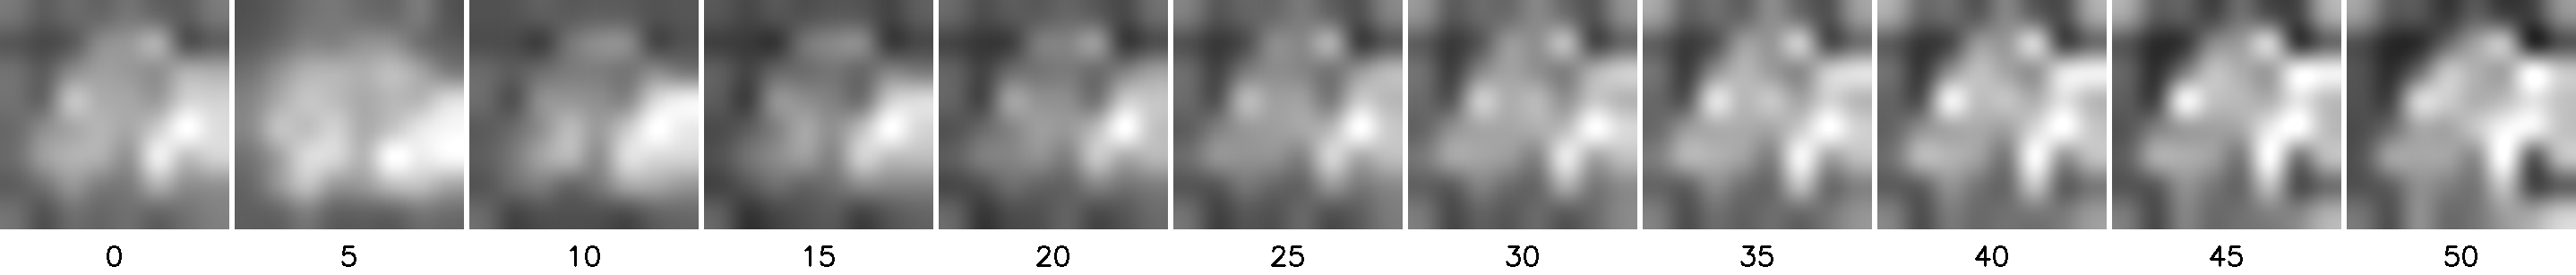

In [127]:
res = 8
steps = list(range(0, 51, 5))
num_pixels = res ** 2

attention_map_per_step = []
for step_num in steps:
    out = []
    attention_maps = {key: [item / len(values) for item in values] for key, values in controller.all_steps_store[step_num].items()}
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res)[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    attention_map = out.cpu()
    attention_map_per_step.append(attention_map)

images = []
for s, image in zip(steps, attention_map_per_step):
    image = 255 * image / image.max()
    image = image.unsqueeze(-1).expand(*image.shape, 3)
    image = image.numpy().astype(np.uint8)
    image = np.array(Image.fromarray(image).resize((256, 256)))
    image = ptp_utils.text_under_image(image, str(s))
    images.append(image)
ptp_utils.view_images(np.stack(images, axis=0))


# Create large scale examples

In [ ]:
height = width = 512
res = []
for s in range(50):
    g_cpu = torch.Generator().manual_seed(s)
    prompts = ["A white dog and a balck cat"]
    latent = torch.randn((1, ldm_stable.unet.in_channels, height // 8, width // 8), generator=g_cpu)
    latents = latent.expand(1,  ldm_stable.unet.in_channels, height // 8, width // 8).to(ldm_stable.device)

    controller = AttentionStoreAll() # AttentionStore()
    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=g_cpu, low_resource=LOW_RESOURCE)
    # image, x_t = run_and_display(prompts, controller, latent=latents, run_baseline=False, generator=g_cpu)
    res.append({'image': image, 'attention_scores': controller.all_steps_store})
    print('#' * 10 + ' {} '.format(s) + '#' * 10)

import pickle

ans = [1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0]
print(len(ans))
for label, item in zip(ans, res):
    item['label'] = label
    
with open('/home/royhirsch/image_editing/notebooks/res2.pickle', 'wb') as f:
    pickle.dump(res, f)


  0%|          | 0/51 [00:00<?, ?it/s]

########## 0 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 1 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 2 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 3 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 4 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 5 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 6 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 7 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 8 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

########## 9 ##########


  0%|          | 0/51 [00:00<?, ?it/s]

# Analysis

In [12]:
import pickle

with open('/home/royhirsch/image_editing/notebooks/res2.pickle', 'rb') as f:
    res = pickle.load(f)

(50, 64) (50,)


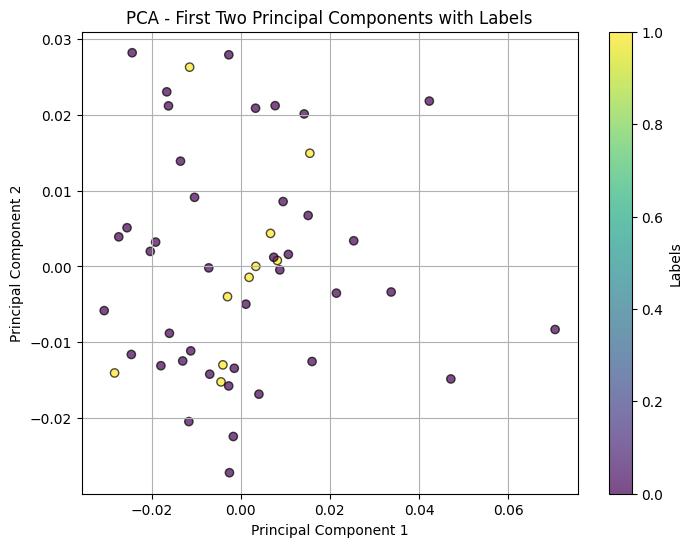

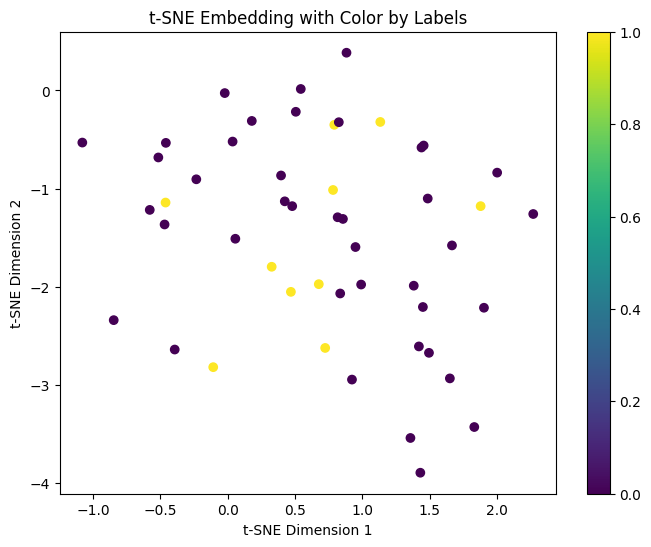

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

step = 50
block_type = 'mid_cross'
block_num = 0

x = []
y = []
for item in res:
    x.append(np.mean(item['attention_scores'][step][block_type][block_num].numpy(), 0))
    y.append(item['label'])
 
x = np.stack(x)
y = np.asarray(y)
print(x.shape, y.shape)

mat = x
labels = y

# Calculate PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mat)

# Plot the first two principal components with labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - First Two Principal Components with Labels")
plt.colorbar(scatter, label="Labels")  # Color bar for label reference
plt.grid(True)
plt.show()

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(x)

# Visualize the embedded data with colors
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis')
plt.title('t-SNE Embedding with Color by Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()


In [119]:
step = 20
block_type = 'mid_cross'
block_num = 0

centers = []
for step in range(len(item['attention_scores'])):
    x = []
    y = []
    for item in res:
        x.append(np.mean(item['attention_scores'][step][block_type][block_num].numpy(), 0))
        y.append(item['label'])
        
    x = np.stack(x)
    y = np.stack(y)

    x_pos = x[y == 1, :]
    x_neg = x[y == 0, :]
    # print(x_pos.shape, x_neg.shape)

    x_pos_cluster = np.mean(x_pos, 0)
    x_neg_cluster = np.mean(x_neg, 0)

    neg_to_pos_cluster = x_neg_cluster - x_pos_cluster
    neg_to_pos_cluster /= np.linalg.norm(neg_to_pos_cluster)
    neg_to_pos_cluster = torch.from_numpy(neg_to_pos_cluster)
    centers.append(neg_to_pos_cluster)
 

class AttentionModify(AttentionStoreAll):
    
    def __init__(self, block_type=block_type.split('_')[0], centers=centers, alpha=1., strat_from=0, end_at=51):
        super(AttentionStoreAll, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}
        self.all_steps_store = []
        self.text_input_save_ind = 9
        
        self.block_type = block_type
        self.alpha = alpha
        self.centers = centers
        self.strat_from = strat_from       
        self.end_at = end_at
        
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            attn_slice = attn[:, :, self.text_input_save_ind]
            attn_slice = attn_slice.detach().cpu()
            self.step_store[key].append(attn_slice)
        if place_in_unet == self.block_type:
            cur_step = len(self.all_steps_store)
            if cur_step >= self.strat_from and cur_step < self.end_at:
                attn[:, :, self.text_input_save_ind] = attn[:, :, self.text_input_save_ind] + self.centers[cur_step].to(attn.device) * self.alpha
        return attn

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.all_steps_store.append(self.step_store)
            self.between_steps()
        return attn


  0%|          | 0/51 [00:00<?, ?it/s]

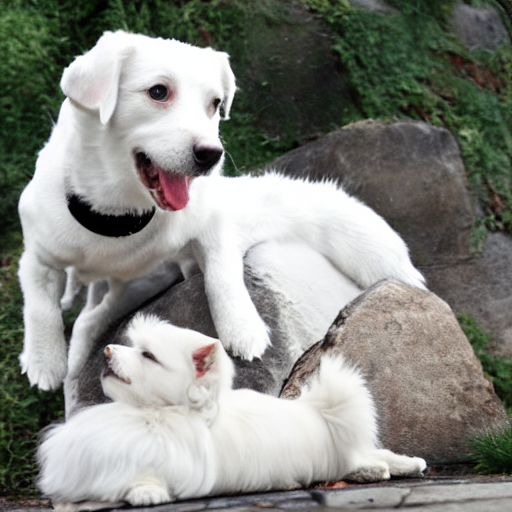

In [121]:
height = width = 512
g_cpu = torch.Generator().manual_seed(68)
prompts = ["A white dog and a balck cat"]
latent = torch.randn((1, ldm_stable.unet.in_channels, height // 8, width // 8), generator=g_cpu)
latents = latent.expand(1,  ldm_stable.unet.in_channels, height // 8, width // 8).to(ldm_stable.device)

controller = AttentionModify(alpha=7, strat_from=0, end_at=50)
image, x_t = run_and_display(prompts, controller, latent=latents, run_baseline=False, generator=g_cpu)

  0%|          | 0/51 [00:00<?, ?it/s]

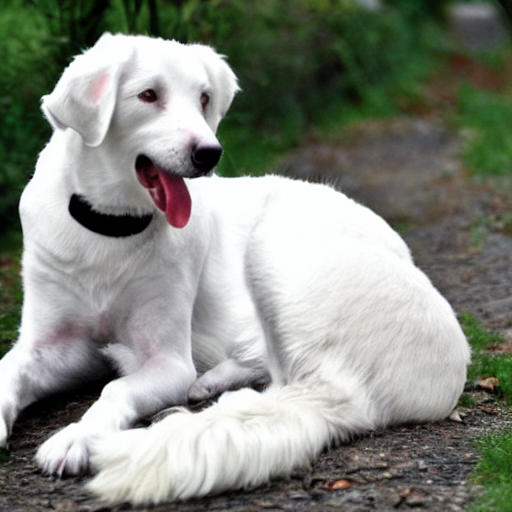

In [107]:
height = width = 512
g_cpu = torch.Generator().manual_seed(68)
prompts = ["A white dog and a balck cat"]
latent = torch.randn((1, ldm_stable.unet.in_channels, height // 8, width // 8), generator=g_cpu)
latents = latent.expand(1,  ldm_stable.unet.in_channels, height // 8, width // 8).to(ldm_stable.device)

controller = AttentionStoreAll()
image, x_t = run_and_display(prompts, controller, latent=latents, run_baseline=False, generator=g_cpu)
